# 3.SENet_Student_Practice.ipynb 說明
本 notebook 主要是讓學生練習實作 SENet（Squeeze-and-Excitation Network）相關的深度學習技術。內容通常包含：
1. **SENet 理論簡介**：說明 SENet 的設計理念、結構與優點。
2. **PyTorch 實作**：指導學生如何用 PyTorch 實作 SENet Block，並將其整合到 CNN 架構中。
3. **資料前處理與載入**：包含資料集的下載、解壓縮、前處理（如正規化、資料增強）與 DataLoader 建立。
4. **模型訓練與驗證**：設計訓練流程，記錄 loss 與 accuracy，並可視覺化訓練過程。
5. **模型評估與測試**：對測試集進行預測，並計算分類指標。
6. **實作練習區**：通常會有留白或提示，讓學生自行補上 SENet Block 或相關程式碼。
本 notebook 適合用於課堂教學或自學，幫助學生理解並動手實作現代 CNN 架構中的注意力機制（Attention Mechanism）。

In [1]:
# import package
import os
import cv2
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

pip install torchsummary


In [2]:
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用Nvidia顯卡
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # 使用M-series SoC

# 一、SE Net
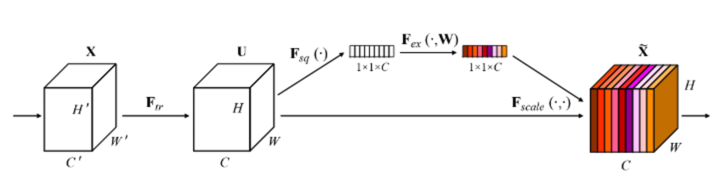

SE Net（Squeeze-and-Excitation Network，壓縮與激勵網路）是一種用於提升卷積神經網路（CNN）表現的注意力機制。它的核心思想是讓網路自動學習「每個通道（channel）」的重要性，進而加強有用特徵、抑制無用特徵。

In [3]:
class SENet(nn.Module):
    def __init__(self, in_channels, reduction_ratio = 16):
        super(SENet, self).__init__()
        
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.FC = nn.Sequential(nn.Linear(in_features = in_channels, out_features = int(in_channels // reduction_ratio)),
                                nn.ReLU(),
                                nn.Linear(in_features = int(in_channels // reduction_ratio), out_features = in_channels),
                                nn.Sigmoid())
        
    def forward(self,x):
        
        b,c,h,w = x.size()
        squeeze = self.GAP(x).view(b,c)        #(c,1,1) -> (c,)
        excitation = self.FC(squeeze)          #(c,)
        excitation = excitation.view(b,c,1,1)  # (c, ) -> (c,1,1)
        
        output = torch.multiply(x, excitation)
        
        return output
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv = nn.Conv2d(32, 128, kernel_size = 3, padding = 1)
        self.SE = SENet(in_channels = 128, reduction_ratio = 16)
        
    def forward(self, x):
        return self.SE(self.conv(x))
    
cnn_model = CNN().to(device)
print(cnn_model)
summary(cnn_model, input_size=(32, 224, 224))
        

CNN(
  (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (SE): SENet(
    (GAP): AdaptiveAvgPool2d(output_size=(1, 1))
    (FC): Sequential(
      (0): Linear(in_features=128, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=128, bias=True)
      (3): Sigmoid()
    )
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]          36,992
 AdaptiveAvgPool2d-2            [-1, 128, 1, 1]               0
            Linear-3                    [-1, 8]           1,032
              ReLU-4                    [-1, 8]               0
            Linear-5                  [-1, 128]           1,152
           Sigmoid-6                  [-1, 128]               0
             SENet-7        [-1, 128, 224, 224]               0
Total params: 39,176
Trainable params: 39,176
Non-trainable params: 0
----------

### 設計ResidualSEN

In [4]:
class ResidualSE(nn.Module):
    def __init__(self, in_channels, out_channels, reduction_ratio = 16):
        super(ResidualSE, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(in_channels)
        
        self.fc = nn.Sequential(nn.Linear(in_features = in_channels, out_features = in_channels // reduction_ratio),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features = in_channels // reduction_ratio, out_features = in_channels),
                                nn.Sigmoid())
        
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.Flatten = nn.Flatten()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        short_cut = x
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        
        # SE Module
        b,c,_,_ = x.size()
        squeeze = self.GAP(x).view(b,c)
        excitation = self.fc(squeeze).view(b,c,1,1)
        output = torch.multiply(x, excitation)
        
        # skip connection
        output = x + output
        
        return self.relu(output)
    

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.ResidualSE_1 = ResidualSE(in_channels = 32, out_channels = 32)

    def forward(self, x):
        x = self.ResidualSE_1(x)
        
        return x
    

cnn_model = CNN().to(device)
print(cnn_model)
summary(cnn_model, input_size=(32, 224, 224))

CNN(
  (ResidualSE_1): ResidualSE(
    (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=2, out_features=32, bias=True)
      (3): Sigmoid()
    )
    (GAP): AdaptiveAvgPool2d(output_size=(1, 1))
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (relu): ReLU(inplace=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1   

# 二、Answer of the Inception SE model

### 設計InceptionSEN

In [6]:
class InceptionSEN(nn.Module):
    def __init__(self, in_channels, out_channels, reduction_ratio = 16):
        super(InceptionSEN, self).__init__()
        
        self.ConvA_1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                                     nn.ReLU(inplace=True))
        
        self.ConvB_1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                                     nn.ReLU(inplace=True))
        self.ConvB_2 = nn.Sequential(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
                                     nn.ReLU(inplace=True))
        
        self.ConvC_1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                                           nn.ReLU(inplace=True))
        self.ConvC_2 = nn.Sequential(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=5, padding=2),
                                           nn.ReLU(inplace=True))
        
        self.ConvD_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.ConvD_1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                                     nn.ReLU(inplace=True))
        # SE module的架構
        self.fc = nn.Sequential(nn.Linear(in_features = out_channels*4, out_features = (out_channels*4) // reduction_ratio),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features = (out_channels*4) // reduction_ratio, out_features = out_channels*4),
                                nn.Sigmoid())
        
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
     
    def forward(self, x):
        # Inception Module
        out1 = self.ConvA_1(x)
        out2 = self.ConvB_2(self.ConvB_1(x))
        out3 = self.ConvC_2(self.ConvC_1(x))
        out4 = self.ConvD_1(self.ConvD_pool(x))
        
        out = torch.cat([out1, out2, out3, out4], dim=1)
        
        # SE Module
        # 在這邊實作 SE Module:

        return out

### 設計6層inceptionSE Net model

In [7]:
Inception_List = [2,2,2]
filter_Inception = [64, 64*2, 64*4]
class CNN(nn.Module):
    def __init__(self, Inception_List, filter_Inception):
        super(CNN, self).__init__()
        #conv stem with max pooling
        self.conv = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1),)
        
        self.Inception_1 = self.Inception_Module(num = Inception_List[0], 
                                                 in_channel = 32, 
                                                 output_channel = filter_Inception[0], 
                                                 dw = True)
        
        self.Inception_2 = self.Inception_Module(num = Inception_List[1], 
                                                 in_channel = filter_Inception[0]*4, 
                                                 output_channel = filter_Inception[1], 
                                                 dw = True)
        
        self.Inception_3 = self.Inception_Module(num = Inception_List[2], 
                                                 in_channel = filter_Inception[1]*4, 
                                                 output_channel = filter_Inception[2], 
                                                 dw = False)
        
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        # 全連接層（包含輸出層）
        self.fc = nn.Sequential(nn.Linear(in_features = filter_Inception[2]*4, out_features = 128),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features = 128, out_features = 10))
    
    def Inception_Module(self, num, in_channel, output_channel, dw = True):
        layers = []
        # 初始值就是輸入的in_channel
        in_channel = in_channel
        
        for i in range(num):
            layers.append(InceptionSEN(in_channels = in_channel, out_channels = output_channel))
            # 由於輸出的channel數量變成output_channel * 4, 所以要改變in_channels的輸入
            in_channel = output_channel*4
        
        if dw == True:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.Inception_1(x)
        x = self.Inception_2(x)
        x = self.Inception_3(x)
        
        b,c,_,_ = x.size()
        GAP_output = self.GAP(x).view(b,c)
        output = self.fc(GAP_output)
        
        return output

cnn_model = CNN(Inception_List = Inception_List, filter_Inception = filter_Inception).to(device)
#print(cnn_model)
summary(cnn_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           2,112
              ReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]           2,112
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           2,112
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]         102,464
             ReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14           [-1, 32,

# 三、使用Cifar 10 資料集訓練

## 1. 讀取cifar10，並做資料預處理，包含rescale, 資料擴增

In [8]:
# Cifar-10 data
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(p=0.5),])
                                      #transforms.RandomResizedCrop((32, 32)),])

transform_test = transforms.Compose([transforms.ToTensor(),])

In [9]:
# Data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



100%|██████████| 170M/170M [01:05<00:00, 2.62MB/s] 


## 2. data loader

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

## 3. 編譯模型

In [15]:
# 選用Adam為optimizer
# Parameters
# pytorch的CrossEntropyLoss在計算時，會以softmax的輸出作為最後的結果

criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 30

optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=4)


## 4. Training

In [ ]:
def Show_Train_flow(train_cnnmodel, test_cnnmodel, Show = 'loss', Title='Training accuracy comparision'):
    plt.plot(train_cnnmodel)
    plt.plot(test_cnnmodel)
    plt.title(Title)
    plt.ylabel(Show)
    plt.xlabel('Epoch')
    plt.legend(['train','test'])
    plt.show()

cnn_loss_history = []
Show_Train_flow(cnn_loss_history, cnn_valloss_history, Show = 'loss', Title='cnn loss comparision')
Show_Train_flow(cnn_acc_history, cnn_valacc_history, Show = 'acc', Title='cnn acc comparision')

NameError: name 'cnn_loss_history' is not defined

In [ ]:
# 訓練過程
# len(trainloader) : 訓練集總共的資料量 / batch
# len(trainloader.dataset) : 訓練集總共的資料量

cnn_loss_history = []
cnn_acc_history = []

cnn_valloss_history = []
cnn_valacc_history = []

for epoch in range(epochs):
    # 訓練階段
    cnn_model.train()
    running_loss = 0.0
    accuracy = 0.0
    total = 0.0
    
    progress = tqdm(total=len(trainloader)-1,position=0)
    for times, data_train in enumerate(trainloader, 0):
        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_cnn.zero_grad()

        # model Feedforward
        output_train = cnn_model(inputs)
        
        # Feed forward loss result
        loss = criterion(output_train, labels)
        
        # backward update
        loss.backward()
        
        # optimize
        optimizer_cnn.step()

        # Compute loss
        running_loss += loss.item()
        
        # Compute accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        
        progress.update(1)
        if times+1 == len(trainloader):
            print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f,' % (epoch+1, 
                                                             epochs, 
                                                             times+1, 
                                                             len(trainloader), 
                                                             running_loss/len(trainloader),
                                                             accuracy / total),end = " ")
            cnn_loss_history.append(running_loss/len(trainloader))
            cnn_acc_history.append(accuracy / total)
            running_loss = 0.0

    # 測試階段
    cnn_model.eval()
    test_loss = 0.0
    accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testLoader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)
            
            # model predict    
            output_test = cnn_model(inputs)
            
            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()
            
            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
            if times+1 == len(testLoader):
                
                scheduler.step(test_loss / len(testLoader))
                print('test_loss: %.3f, test_acc: %.3f' % (test_loss / len(testLoader),
                                                           accuracy / total))
                
                cnn_valloss_history.append(test_loss / len(testLoader))
                cnn_valacc_history.append(accuracy / total)
                test_loss = 0.0
            

print('Finished Training')

  0%|          | 0/1562 [00:00<?, ?it/s]

NameError: name 'trainLoader' is not defined